In [131]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
from itkwidgets import view   
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]
from aicssegmentation.core.MO_threshold import MO

# dots
from aicssegmentation.core.seg_dot import dot_3d, dot_3d_wrapper 
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball     # function for post-processing (size filter)
from skimage.feature import peak_local_max
from skimage.measure import label
from scipy.ndimage import distance_transform_edt

# lamp1
from aicssegmentation.core.vessel import filament_2d_wrapper
from aicssegmentation.core.seg_dot import dot_2d_slice_by_slice_wrapper
from aicssegmentation.core.utils import hole_filling
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_slice_by_slice
from skimage.morphology import remove_small_objects, watershed, dilation, erosion, ball  
import warnings
warnings.filterwarnings('ignore')

#shell
from aicssegmentation.core.utils import get_middle_frame, hole_filling, get_3dseed_from_mid_frame
from aicssegmentation.core.pre_processing_utils import intensity_normalization, image_smoothing_gaussian_3d

from skimage import filters as skfilters
import numpy as np
import matplotlib.pyplot as plt
from aicsimageio import AICSImage
from skimage import filters as skfilters

In [134]:
filename = "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/h2b/deconvolution/tiff-decon/H2B-sc09-p1-c02-deconvolution.tiff"
reader = AICSImage(filename) 
IMG = reader.data.astype(np.float32)

print(IMG.shape)

Attempted file (//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/h2b/deconvolution/tiff-decon/H2B-sc09-p1-c02-deconvolution.tiff) load with reader: aicsimageio.readers.ome_tiff_reader.OmeTiffReader failed with error: Could not find a schema for XML resource XMLResource(root=<Element '{http://www.openmicroscopy.org/Schemas/OME/2016-06}OME' at 0x7fd11fcbd050>).
<tifffile.TiffFrame 260 @301241684> is missing required tags
<tifffile.TiffFile 'H2B-sc09-p1-c02-…onvolution.tiff'> OME series expected 260 frames, got 261
<tifffile.TiffFrame 260 @301241684> is missing required tags
<tifffile.TiffFile 'H2B-sc09-p1-c02-…onvolution.tiff'> OME series expected 260 frames, got 261


(1, 4, 65, 624, 924)


In [135]:
reader

<AICSImage [Reader: TiffReader, Image-is-in-Memory: True]>

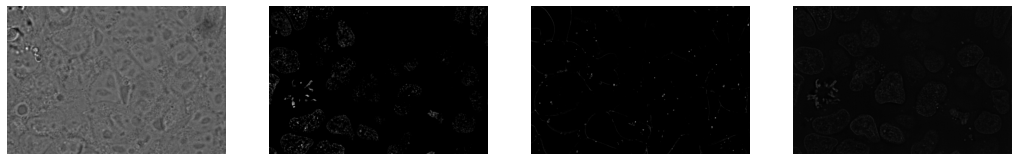

In [122]:
N_CHANNELS = IMG.shape[1] # N_CHANNELS = IMG.shape[1] 
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
if N_CHANNELS==1:
    ax.axis('off')
    ax.imshow(IMG[0,0,MID_SLICE,:,:], cmap=plt.cm.gray)
else:
    for channel in range(N_CHANNELS):
        ax[channel].axis('off')
        ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

In [123]:
#####################
structure_channel = 1

#####################

struct_img0 = IMG[0,structure_channel,:,:,:].copy()

# view(single_fluorescent_view(struct_img0))

<h1> Experimental <h1>

In [124]:
################################
## PARAMETERS for this step ##
intensity_scaling_param = [1,5.5] # current: [1,5.5]
gaussian_smoothing_sigma = 1
################################
# intensity normalization
struct_img = intensity_normalization(struct_img0, scaling_param=intensity_scaling_param)


# smoothing with gaussian filter
structure_img_smooth = image_smoothing_gaussian_3d(struct_img, sigma=gaussian_smoothing_sigma)

# view(single_fluorescent_view(structure_img_smooth))


In [125]:
# Mask Object Thresholding
bw1, object_for_debug = MO(structure_img_smooth, global_thresh_method='ave', object_minArea=700, return_object=True, 
                          local_adjust=1.95)

In [126]:
# Otsu thresholding
# increase th, thinner/less segmentation. decrease th, chunkier/more segmentation.
th = 3.60* threshold_otsu(structure_img_smooth) # original at 1.4 # current: 3.90
overall_shape = dilation(
    remove_small_objects(structure_img_smooth > th, min_size=1, connectivity=1, in_place=False), #min_size = 10
    ball(1)
)
fixed_shape = erosion(
    hole_filling(overall_shape, hole_min=0, hole_max=5, fill_2d=True), #, hole_min= 0 hole_max = 5
    ball(1)
)

# view(segmentation_quick_view(fixed_shape))

In [127]:
bw_merge = np.logical_or(bw1, fixed_shape)

In [128]:
################################
## PARAMETERS for this step ##
minArea = 50 # original: 5
################################

seg = remove_small_objects(fixed_shape>0, min_size=minArea, connectivity=1) # bw>0 # connectivity=1 #in_place=False

In [129]:
out=seg.astype(np.uint8)
out[out>0]=255

imsave("deconseg-sc09-p01-c02.tiff", out) 